# Week 4: Using real world data

In [1]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

2024-07-13 09:38:28.442460: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-13 09:38:28.442575: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-13 09:38:28.578163: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
TEMPERATURES_CSV = '/kaggle/input/daily-minimum-temperatures-in-melbourne/daily-min-temperatures.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")    
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

## Parsing the raw data

In [8]:
def parse_data_from_file(filename):
    
    times = []
    temperatures = []

    with open(filename) as csvfile:
        
        ### START CODE HERE
        
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            times.append((row[0]))
            temperatures.append(float(row[1]))
    times = np.array(times)
    temperatures = np.array(temperatures)
        ### END CODE HERE
            
    return times, temperatures

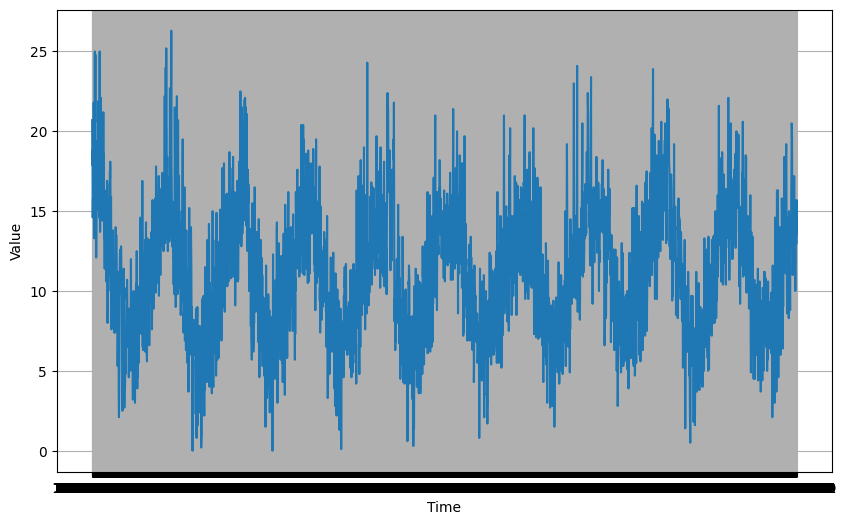

In [9]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TEMPERATURES_CSV = '/kaggle/input/daily-minimum-temperatures-in-melbourne/daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data

In [10]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [11]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

## Defining the model architecture

In [34]:
def create_uncompiled_model():

    ### START CODE HERE
    
    model = tf.keras.models.Sequential([
       tf.keras.layers.Conv1D(filters=128, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[None, 1]),
      tf.keras.layers.LSTM(128, return_sequences=True),
      tf.keras.layers.LSTM(128),
      tf.keras.layers.Dense(60, activation="relu"),
      tf.keras.layers.Dense(30, activation="relu"),
      tf.keras.layers.Dense(1)
    ]) 
    
    ### END CODE HERE

    return model

In [35]:
# Test your uncompiled model
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(train_set)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Your current architecture is compatible with the windowed dataset! :)


## Adjusting the learning rate - (Optional Exercise)

In [36]:
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
    
    ### START CODE HERE
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber,
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    ### END CODE HERE
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [37]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 10.2985 - mae: 10.7970 - learning_rate: 1.0000e-06
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 10.3163 - mae: 10.8158 - learning_rate: 1.1220e-06
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 10.2801 - mae: 10.7786 - learning_rate: 1.2589e-06
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 10.3848 - mae: 10.8840 - learning_rate: 1.4125e-06
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 10.0470 - mae: 10.5461 - learning_rate: 1.5849e-06
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 10.1879 - mae: 10.6860 - learning_rate: 1.7783e-06
Epoch 7/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 10.1207 - mae: 10.6193 - learning_rate: 1.9953e-06
Epoch 8/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.9955 - mae: 10.4945 - learning_rate: 2.2387e-06
Epoch 9/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.8899 - mae: 10.3879 - learning_rate: 2.5119e-06
Epoch

(0.0001, 10.0, 0.0, 10.0)

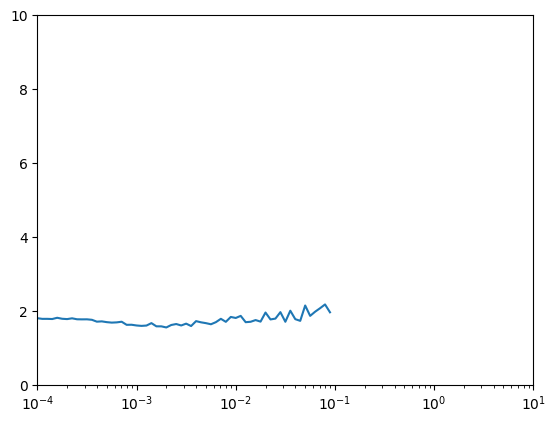

In [38]:
plt.semilogx(lr_history.history["learning_rate"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

## Compiling the model

In [39]:
def create_model():

    tf.random.set_seed(51)
    
    model = create_uncompiled_model()

    ### START CODE HERE
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.0891, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber,
                  optimizer=optimizer,
                  metrics=["mae"])  
    
    ### END CODE HERE

    return model

In [40]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=50)

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.0374 - mae: 5.5141
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.8662 - mae: 3.3330
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.8872 - mae: 3.3601
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.7929 - mae: 3.2562
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.8084 - mae: 3.2769
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.8049 - mae: 3.2748
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.7761 - mae: 3.2441
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7972 - mae: 3.2652
Epoch 9/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.7807 - mae: 3.2442
Epoch 10/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.7574 - mae: 3.2257
Epoch 11/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.8301 - mae: 3.2981
Epoch 12/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.8007 - mae: 3.2697
Epoch 13/50
77/77 ━━━━━━━━━━━━━━━━━━━━

## Evaluating the forecast

In [41]:
def compute_metrics(true_series, forecast):
    ### START CODE HERE
    mse = tf.keras.metrics.MeanSquaredError()
    mse.update_state(true_series, forecast)
    mse_result = mse.result().numpy()
    
    mae = tf.keras.metrics.MeanAbsoluteError()
    mae.update_state(true_series, forecast)
    mae_result = mae.result().numpy()
    ### END CODE HERE

    return mse_result, mae_result

## Faster model forecasts

In [42]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


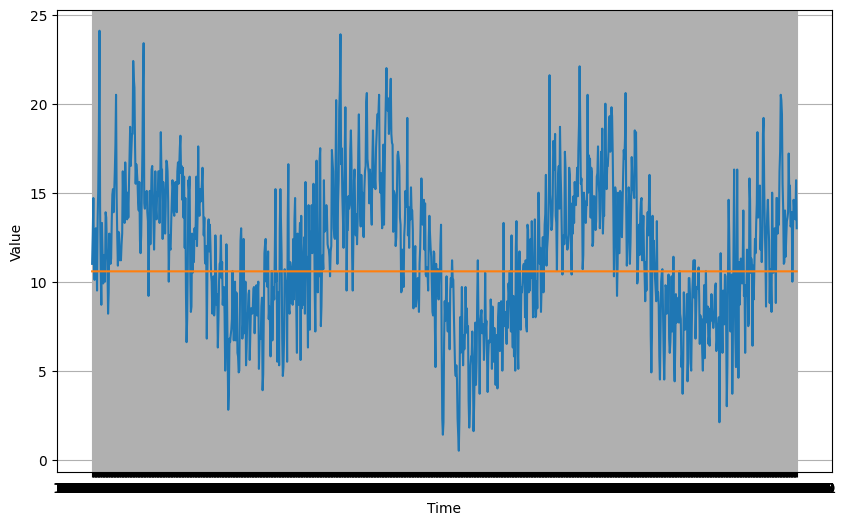

In [43]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [44]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 16.92, mae: 3.35 for forecast
